In [1]:
from cart import DecisionTreeCART
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
borrower_df = pd.read_csv('data/Borrower.csv')
loan_df = pd.read_csv('data/Loan.csv')

loan_feature = loan_df[['loanId', 'memberId', 'isJointApplication',
                        'loanAmount', 'term', 'interestRate',
                        'monthlyPayment', 'grade', 'loanStatus']]
loan_feature.set_index('loanId')

borrower_feature = borrower_df[['memberId', 'yearsEmployment',
                                'homeOwnership', 'annualIncome',
                                'dtiRatio', 'lengthCreditHistory',
                                'numTotalCreditLines',
                                'numOpenCreditLines',
                                'numOpenCreditLines1Year',
                                'revolvingBalance',
                                'revolvingUtilizationRate',
                                'numDerogatoryRec',
                                'numDelinquency2Years',
                                'numChargeoff1year',
                                'numInquiries6Mon']]
borrower_feature.set_index('memberId')

merged_df = pd.merge(borrower_feature, loan_feature, on='memberId')
merged_df.sort_values(['memberId', 'loanId'], ascending=True)
merged_df = merged_df.set_index(['loanId', 'memberId'])

mode_jointapp = merged_df.isJointApplication.mode()[0]
mean_loan = round(merged_df.loanAmount.mean())
mode_term = merged_df.term.mode()[0]
mean_numopen = round(merged_df.numOpenCreditLines.mean())

merged_df[["isJointApplication"]] = merged_df[[
    "isJointApplication"]].fillna(value=mode_jointapp)
merged_df[["loanAmount"]] = merged_df[[
    "loanAmount"]].fillna(value=mean_loan)
merged_df[["term"]] = merged_df[["term"]].fillna(value=mode_term)
merged_df[["numOpenCreditLines"]] = merged_df[[
    "numOpenCreditLines"]].fillna(value=mean_numopen)

In [ ]:
replace_dict = {
    'yearsEmployment': {
        '< 1 year': 0.5,
        '1 year': 1,
        '2-5 years': 3,
        '6-9 years': 8,
        '10+ years': 12,
    },
    'homeOwnership': {
        'rent': 0,
        'mortgage': 1,
        'own': 2,
    },
    'loanStatus': {
        'Default': 0,
        'Current': 1,
    },
    'term': {
        '60 months': 60,
        '48 months': 48,
        '36 months': 36,
    },
    'grade': {
        'A1': 1,
        'A2': 2,
        'A3': 3,
        'B1': 4,
        'B2': 5,
        'B3': 6,
        'C1': 7,
        'C2': 8,
        'C3': 9,
        'D1': 10,
        'D2': 11,
        'D3': 12,
        'E1': 13,
        'E2': 14,
        'E3': 15,
    }
}

cleaned_df = merged_df.replace(replace_dict)
cleaned_df.to_csv('data/loan_cleaned_unbalanced.csv')

In [ ]:
class_yes = cleaned_df[cleaned_df['loanStatus'] == 1]
class_no = cleaned_df[cleaned_df['loanStatus'] == 0]

n = round(len(class_no) * 1.5)
balanced_df = class_no.append(class_yes.sample(n))
balanced_df.to_csv('data/loan_cleaned_balanced_under_sampling.csv')

In [ ]:
class_yes = cleaned_df[cleaned_df['loanStatus'] == 1]
class_no = cleaned_df[cleaned_df['loanStatus'] == 0]

n = round(len(class_yes) / len(class_no))
over_sampling_df = class_yes.append(class_no)

for i in range(n-2):
    over_sampling_df = over_sampling_df.append(class_no)

over_sampling_df.to_csv('data/loan_cleaned_balanced_over_sampling.csv')

In [ ]:
train_df = cleaned_df.sample(1000)
train_np = np.array(train_df.values)
test_np = np.array(cleaned_df.sample(100).values)

X_train = train_np[:, :-1]
y_train = train_np[:, len(train_np[0]) - 1]

X_test = test_np[:, :-1]
y_test = test_np[:, len(train_np[0]) - 1]

clf = DecisionTreeCART()
clf.fit(X_train, y_train)

In [ ]:
predicted = clf.predict(X_test)

pred_true = 0
tn = 0
tp = 0
fn = 0
fp = 0
for i in range(len(predicted)):
    if predicted[i] == y_test[i]:
        pred_true += 1
        if y_test[i] == 0:
            tn += 1
        else:
            tp += 1
    else:
        if y_test[i] == 1:
            fn += 1
        else:
            fp += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print('Predicted True = ' + str(pred_true) + ' out of ' + str(len(y_test)))
print('Precision      = ', precision)
print('Recall         = ', recall)
print('True Positive  = ', tp)
print('True Negative  = ', tn)
print('False Positive = ', fp)
print('False Negative = ', fn)
print('F1 Score       = ', f1)

# Model Training

In [2]:
dataset_df = pd.read_csv('data/loan_cleaned_unbalanced.csv').set_index(['loanId', 'memberId'])
dataset_df.head()

,,yearsEmployment,homeOwnership,annualIncome,dtiRatio,lengthCreditHistory,numTotalCreditLines,numOpenCreditLines,numOpenCreditLines1Year,revolvingBalance,revolvingUtilizationRate,...,numDelinquency2Years,numChargeoff1year,numInquiries6Mon,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,loanStatus
loanId,memberId,,,,,,,,,,,,,,,,,,,,,
1888978,2305095,12.0,0,56471,16.80,6,11,9.0,6,14301,49.02,...,19,10,0,0.0,25190.0,60,6.25,490,15,1
1299695,2610493,3.0,0,55038,19.99,22,8,7.0,4,18262,72.40,...,0,0,0,0.0,21189.0,60,10.49,455,6,1
1875016,2491679,0.5,0,56610,14.33,5,8,5.0,5,10799,66.27,...,1,1,0,0.0,29908.0,60,9.11,622,5,1
1440478,2092798,8.0,2,54887,14.80,12,14,7.0,3,15272,61.05,...,0,0,3,0.0,13053.0,48,11.89,343,6,1
1124634,2633077,3.0,0,53522,10.14,4,21,19.0,10,19316,56.39,...,14,7,1,0.0,24613.0,60,15.13,587,3,1


In [3]:
dataset_np = dataset_df.sample(1110).values
train_size = round(0.9 * len(dataset_np))
np.random.shuffle(dataset_np)
train_np = np.array(dataset_np[:train_size,:])
test_np = np.array(dataset_np[train_size:,:])

X_train = train_np[:, :-1]
y_train = train_np[:, len(train_np[0]) - 1]

X_test = test_np[:, :-1]
y_test = test_np[:, len(train_np[0]) - 1]

In [ ]:
clf = DecisionTreeCART()
clf.fit(X_train, y_train, max_depth=10, min_size=1)

In [ ]:
predicted = clf.predict(X_test)

pred_true = 0
tn = 0
tp = 0
fn = 0
fp = 0
for i in range(len(predicted)):
    if predicted[i] == y_test[i]:
        pred_true += 1
        if y_test[i] == 0:
            tn += 1
        else:
            tp += 1
    else:
        if y_test[i] == 1:
            fn += 1
        else:
            fp += 1

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print('Predicted True = ' + str(pred_true) + ' out of ' + str(len(y_test)))
print('Precision      = ', precision)
print('Recall         = ', recall)
print('True Positive  = ', tp)
print('True Negative  = ', tn)
print('False Positive = ', fp)
print('False Negative = ', fn)
print('F1 Score       = ', f1)

In [6]:
depth_range = range(2, 11)
f1_scores = []
accuracy_scores = []

for d in depth_range:
    start_time = time.time()
    clf = DecisionTreeCART()
    clf.fit(X_train, y_train, max_depth=d)
    elapsed_time = time.time() - start_time
    predicted = clf.predict(X_test)

    pred_true = 0
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    for i in range(len(predicted)):
        if predicted[i] == y_test[i]:
            pred_true += 1
            if y_test[i] == 0:
                tn += 1
            else:
                tp += 1
        else:
            if y_test[i] == 1:
                fn += 1
            else:
                fp += 1
    
    accuracy = pred_true/len(y_test)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    print('Max depth = {} done in {}'.format(d, elapsed_time))

Max depth = 2 done in 23.11403512954712
Max depth = 3 done in 28.501824855804443
Max depth = 4 done in 33.58999013900757
Max depth = 5 done in 39.719324827194214
Max depth = 6 done in 40.77224588394165
Max depth = 7 done in 44.418787240982056
Max depth = 8 done in 49.28298592567444
Max depth = 9 done in 51.86401391029358
Max depth = 10 done in 55.33140707015991


In [7]:
f1_max = max(f1_scores)
f1_max_idx = f1_scores.index(f1_max)

acc_max = max(accuracy_scores)
acc_max_idx = accuracy_scores.index(acc_max)

print('F1 Max = {} at Max Depth = {}'.format(f1_max, f1_max_idx+2))
print('Accuracy Max = {} at Max Depth = {}'.format(acc_max, acc_max_idx+2))

F1 Max = 0.986046511627907 at Max Depth = 3
Accuracy Max = 0.972972972972973 at Max Depth = 3


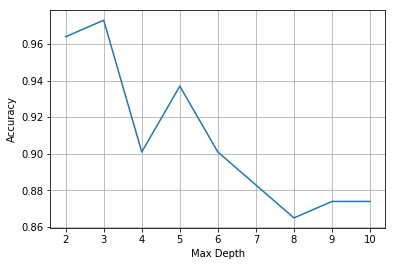

In [8]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

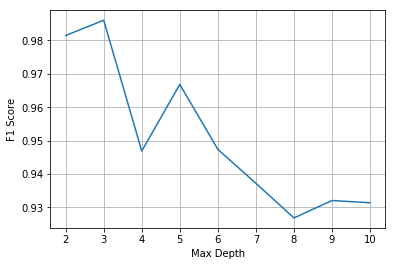

In [9]:
plt.plot(depth_range, f1_scores)
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# Model Training

In [10]:
dataset_df = pd.read_csv('data/loan_cleaned_balanced_under_sampling.csv').set_index(['loanId', 'memberId'])
dataset_df.head()

,,yearsEmployment,homeOwnership,annualIncome,dtiRatio,lengthCreditHistory,numTotalCreditLines,numOpenCreditLines,numOpenCreditLines1Year,revolvingBalance,revolvingUtilizationRate,...,numDelinquency2Years,numChargeoff1year,numInquiries6Mon,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,loanStatus
loanId,memberId,,,,,,,,,,,,,,,,,,,,,
1821279,2124878,1.0,1,47946,27.06,9,9,5.0,5,14027,75.35,...,0,0,1,0.0,17101.0,60,18.01,434,12,0
1891878,2248022,0.5,1,51844,21.72,10,17,15.0,11,12544,77.54,...,0,0,0,0.0,23785.0,36,13.10,803,6,0
1267133,2876501,0.5,0,54799,22.16,3,15,11.0,10,13012,83.94,...,0,0,2,0.0,14246.0,48,14.93,396,15,0
1374863,2027352,8.0,2,52317,12.69,37,10,7.0,6,16751,77.44,...,11,11,3,0.0,17298.0,48,7.07,415,7,0
1679646,2486530,1.0,1,53036,24.30,4,21,19.0,10,12349,100.00,...,0,0,0,0.0,23014.0,36,9.00,732,13,0


In [11]:
dataset_np = dataset_df.sample(1110).values
train_size = round(0.9 * len(dataset_np))
np.random.shuffle(dataset_np)
train_np = np.array(dataset_np[:train_size,:])
test_np = np.array(dataset_np[train_size:,:])

X_train = train_np[:, :-1]
y_train = train_np[:, len(train_np[0]) - 1]

X_test = test_np[:, :-1]
y_test = test_np[:, len(train_np[0]) - 1]

In [12]:
depth_range = range(2, 11)
f1_scores = []
accuracy_scores = []

for d in depth_range:
    start_time = time.time()
    clf = DecisionTreeCART()
    clf.fit(X_train, y_train, max_depth=d)
    elapsed_time = time.time() - start_time
    predicted = clf.predict(X_test)

    pred_true = 0
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    for i in range(len(predicted)):
        if predicted[i] == y_test[i]:
            pred_true += 1
            if y_test[i] == 0:
                tn += 1
            else:
                tp += 1
        else:
            if y_test[i] == 1:
                fn += 1
            else:
                fp += 1
    
    accuracy = pred_true/len(y_test)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    print('Max depth = {} done in {}'.format(d, elapsed_time))

Max depth = 2 done in 19.92070198059082
Max depth = 3 done in 21.520019054412842
Max depth = 4 done in 25.04057788848877
Max depth = 5 done in 27.763875722885132
Max depth = 6 done in 29.418479919433594
Max depth = 7 done in 30.15024995803833
Max depth = 8 done in 31.4666428565979
Max depth = 9 done in 32.357603788375854
Max depth = 10 done in 33.54304265975952


In [13]:
f1_max = max(f1_scores)
f1_max_idx = f1_scores.index(f1_max)

acc_max = max(accuracy_scores)
acc_max_idx = accuracy_scores.index(acc_max)

print('F1 Max = {} at Max Depth = {}'.format(f1_max, f1_max_idx+2))
print('Accuracy Max = {} at Max Depth = {}'.format(acc_max, acc_max_idx+2))

F1 Max = 0.8194444444444444 at Max Depth = 7
Accuracy Max = 0.7657657657657657 at Max Depth = 7


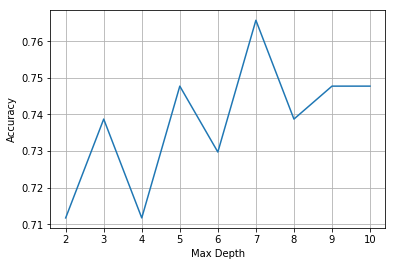

In [14]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

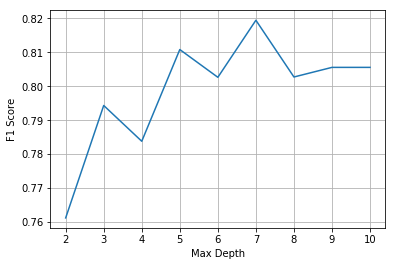

In [15]:
plt.plot(depth_range, f1_scores)
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()